#PK_W281_Vision_Transformers_Pre_Trained_Fine_Tuned_Fine_Label_Test_Images_Cifar100.ipynb

W281 Final Project

April 17, 2023

Waqas Ali | Pedro Melendez | Prakash Krishnan

### Introduction

This notebook complements PK_W281_Vision_Transformers_Cifar100.ipynb by performing evaluation of the random test images on the pre-trained and fine tuned model. Model checkpoints are read from google drive and used for feature extraction and class prediction.




CIFAR-200 Dataset Summary

This dataset has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). 

Data Fields

    image: 32 by 32 RGB image 
    fine label: an integer code specifying the fine label class
    coarse label: mapping of a fine label to a coarse or super-class

Fine Label to Coarse Label Mapping

    mapping = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
    'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
    }


Model Details

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. 

The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels. Next, the model was fine-tuned on ImageNet (also referred to as ILSVRC2012), a dataset comprising 1 million images and 1,000 classes, also at resolution 224x224.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

By pre-training the model, it learns an inner representation of images that can then be used to extract features useful for downstream tasks: if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image.

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import time
import cv2

import glob
import os

import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

from skimage.feature import hog
from sklearn.metrics import accuracy_score

from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

!pip install datasets transformers torch 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Dataset from Hugging Face

In [ ]:
# import CIFAR-100 dataset from HuggingFace

from datasets import load_dataset

dataset_train = load_dataset(
    'cifar100',
    split='train' # training dataset
  # set to True if seeing splits Error
)


# Inspect Train Dataset Shape
display(dataset_train)


dataset_test = load_dataset(
    'cifar100',
    split='test' # training dataset
    )

# Inspect Test Dataset Shape
display(dataset_test)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142. Subsequent calls will reuse this data.


Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 50000
})

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 10000
})

# Setup GPU

In [ ]:
# load in relevant libraries, and alias where appropriate
# This block of code ensures we run it on GPU and NOT CPU

import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

# Mount Drive

In [ ]:
# Mount drive for reading model checkpoints 

from google.colab import drive
drive.mount('/content/drive')

filepath = 'drive/My Drive/Prakash_W281_Final_Project/CIFAR_100/my_model/fine_model' # Read Model Checkpoints

Mounted at /content/drive


# Load Vision Transformers from Hugging Face

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = filepath
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Generate a List of Random Indices from Test Data Set to Compare True Labels and Model Predict Labels

In [ ]:
# Generate 16 Image Indices

image_idx = np.random.randint(0, 1000, size=16, dtype=int)
image_list = [] # Empty List to contain (image, coarse_label_id, coarse_label)

for items in image_idx:
  actual_label = dataset_test["fine_label"][items]
  labels = dataset_test.features['fine_label']
  actual_label, labels.names[actual_label]
  
  image_list.append((dataset_test["img"][items], actual_label, labels.names[actual_label]))


# Function to Display the Test images with True and Predicted Labels

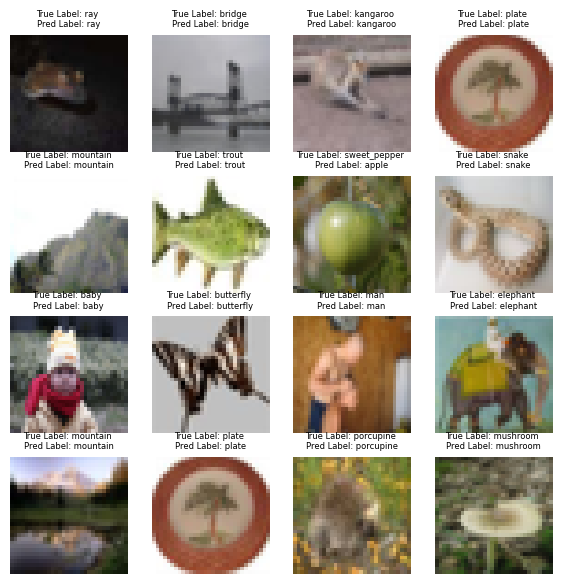

In [ ]:
def display_images(images, title=None):
  
  image_list=[]
  for i in range(len(images)):
    image_list.append((i,i//4,i%4))

  #display(image_list)  

  fig, ax = plt.subplots(4,4, figsize=(7,7))
  if title:
    fig.suptitle(title, fontsize=30)

  for i in range(len(images)):
    fine_label_name = images[i][2]
    img_1 = images[i][0]

    inputs = feature_extractor_finetuned(img_1, return_tensors="pt")

    with torch.no_grad():
      logits = model_finetuned(**inputs).logits

    predicted_label = logits.argmax(-1).item()
    labels = dataset_test.features['fine_label']
    predict_label = labels.names[predicted_label]

    row_index = image_list[i][1]
    col_index = image_list[i][2]
    #print(row_index, col_index)

    ax[row_index, col_index].imshow(img_1)
    ax[row_index, col_index].axis('off')

    ax[row_index,col_index].set_title(f"True Label: {fine_label_name[0:20]} \nPred Label: {predict_label[0:20]}", fontsize="6")

  plt.show()

display_images(image_list)

# Compute Evaluation Metrics

In [ ]:
# Derive Predictions for Test Images

dataset_test_list = [] # Empty List to Store Predictions

# Iterate Through the Dataset
for items in dataset_test:
  img_1 = items["img"]
  actual_label = items["fine_label"]
  labels = dataset_test.features['fine_label']
  actual_label = labels.names[actual_label]

# Get Predictions From Fine Tuned Model
  inputs = feature_extractor_finetuned(img_1, return_tensors="pt")

  with torch.no_grad():
    logits = model_finetuned(**inputs).logits

  predicted_label = logits.argmax(-1).item()
  labels = dataset_test.features['fine_label']
  predict_label = labels.names[predicted_label]

# Append to List
  dataset_test_list.append([items['img'],actual_label, predict_label])

In [ ]:
# Store the Predictions in a Data Frame
dataset_test_results_df = pd.DataFrame (dataset_test_list, columns = ['image', 'actual_label','predicted_label'])

# Extract the Actual and Predicted Labels
y_test_act_arr = dataset_test_results_df[['actual_label']].values.flatten()
y_test_pred_arr = dataset_test_results_df[['predicted_label']].values.flatten()

# Compute Accuracy, Precision, Recall and F1-Score
score_test = accuracy_score(y_test_act_arr, y_test_pred_arr)
print('Accuracy:test=%.3f' % (score_test*100))

score_test = precision_score(y_test_act_arr, y_test_pred_arr, average='macro')
print('Precision:test=%.3f' % (score_test*100))

score_test = recall_score(y_test_act_arr, y_test_pred_arr, average='macro')
print('Recall:test=%.3f' % (score_test*100))

score_test = f1_score(y_test_act_arr, y_test_pred_arr, average='macro')
print('f1_score:test=%.3f' % (score_test*100))

Accuracy:test=89.930
Precision:test=90.108
Recall:test=89.930
f1_score:test=89.952
